In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

# Building Functions we will use later

### Function for plotting

In [3]:
def plot(originalpd, adjustedpd, title, xlegend, ylegend):
    fig  = plt.figure(figsize=(11,7))
    plt.plot(originalpd, color='blue', label=xlegend)
    plt.plot(adjustedpd, color='red', label=ylegend)
    plt.legend(loc='best')
    plt.title(title)
    return plt.show(block=False)

# Function for dickey fuller test

In [4]:
def adftest(adjustedpd):
    adf_test = adfuller(adjustedpd)
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_output['Critical Value (%s)'%key] = value
    
    return print (adf_output)

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [6]:
import pandas as pd

In [7]:
data = pd.read_csv('zillow_data.csv')

In [8]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [9]:
len(data['RegionName'].unique())

14723

In [20]:
data_col_list = list(data.columns)

In [21]:
data_col_list = data_col_list[:7]

In [22]:
data_col_list

['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

In [99]:
data_1 = data[data_col_list]

In [100]:
data_1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
0,84654,60657,Chicago,IL,Chicago,Cook,1
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2
2,91982,77494,Katy,TX,Houston,Harris,3
3,84616,60614,Chicago,IL,Chicago,Cook,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5


In [101]:
data_1.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

In [102]:
data_1['Metro'].value_counts(dropna=False)

NaN                               1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
                                  ... 
Milledgeville                        1
Mount Pleasant                       1
Stephenville                         1
Del Rio                              1
Emporia                              1
Name: Metro, Length: 702, dtype: int64

In [103]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 7 columns):
RegionID      14723 non-null int64
RegionName    14723 non-null int64
City          14723 non-null object
State         14723 non-null object
Metro         13680 non-null object
CountyName    14723 non-null object
SizeRank      14723 non-null int64
dtypes: int64(3), object(4)
memory usage: 805.3+ KB


In [ ]:
df[df['Col2'].isnull()]

In [106]:
data_1_null = data_1[data_1['Metro'].isnull()]

In [107]:
data_1_null.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
151,69340,27410,Greensboro,NC,NaN,Guilford,152
167,69336,27406,Greensboro,NC,NaN,Guilford,168
491,69270,27265,High Point,NC,NaN,Guilford,492
526,69337,27407,Greensboro,NC,NaN,Guilford,527
695,69335,27405,Greensboro,NC,NaN,Guilford,696


In [110]:
for col in data_1_null:
    print('Values for {}:\n{}\n\n'.format(col, data_1_null[col].value_counts(dropna=False)))

Values for RegionID:
94207    1
78557    1
94028    1
78548    1
86737    1
        ..
75130    1
66936    1
66934    1
66932    1
79367    1
Name: RegionID, Length: 1043, dtype: int64


Values for RegionName:
18431    1
27313    1
47042    1
76458    1
76457    1
        ..
15767    1
63660    1
65769    1
14812    1
73728    1
Name: RegionName, Length: 1043, dtype: int64


Values for City:
Greensboro     12
High Point      4
Lexington       4
Carthage        4
West Point      3
               ..
Honesdale       1
Jena            1
Chester         1
Cherokee        1
Prattsville     1
Name: City, Length: 941, dtype: int64


Values for State:
TX    116
TN     68
IN     65
KS     57
MS     55
NY     52
MO     50
MI     42
CA     42
NC     37
MN     36
VA     36
WI     30
GA     28
MT     28
FL     27
ID     23
NH     21
OK     21
CO     20
LA     20
WA     18
OH     18
MD     17
PA     15
UT     12
WY     11
IL     10
ND     10
AL      8
OR      8
KY      7
SC      7
AK      6
NM      5

In [111]:
data_1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
0,84654,60657,Chicago,IL,Chicago,Cook,1
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2
2,91982,77494,Katy,TX,Houston,Harris,3
3,84616,60614,Chicago,IL,Chicago,Cook,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5


In [120]:
data_col_list2 = list(data.columns)

In [121]:
data_col_list2 = data_col_list2[7:]

In [123]:
data_2 = data[data_col_list2]

In [124]:
data_2.isna().sum()

1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
           ... 
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 265, dtype: int64

# Step 2: Data Preprocessing

In [125]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [126]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [46]:
xx = get_datetimes(data)

In [47]:
xx

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Step 3: EDA and Visualization

In [48]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [127]:
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [128]:
list(data.columns[:7])

['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

In [129]:
def melt_data(df):
    melted = pd.melt(df, id_vars=list(data.columns[:7]), var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [130]:
df = melt_data(data)

In [131]:
df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
value    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


In [158]:
inflation = pd.read_csv('CSUSHPINSA.csv')

In [159]:
inflation.head()

,DATE,CSUSHPINSA
0,1987-01-01,63.754
1,1987-02-01,64.155
2,1987-03-01,64.490
3,1987-04-01,64.995
4,1987-05-01,65.569


In [160]:
inflation.describe()

,CSUSHPINSA
count,398.000000
mean,127.945568
std,45.037013
min,63.754000
25%,80.465250
50%,134.081500
75%,167.021250
max,213.159000


In [161]:
inflation['DATE'] = pd.to_datetime(inflation['DATE'])

In [162]:
inflation.set_index('DATE', inplace=True)

In [163]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398 entries, 1987-01-01 to 2020-02-01
Data columns (total 1 columns):
CSUSHPINSA    398 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Filtering the dataframe down to the dates we need

In [164]:



inflation = inflation['1996-04' : '2018-04']

In [165]:
inflation.head()

,CSUSHPINSA
DATE,
1996-04-01,82.144
1996-05-01,82.622
1996-06-01,83.070
1996-07-01,83.443
1996-08-01,83.671


In [166]:
inflation.tail()

,CSUSHPINSA
DATE,
2017-12-01,195.970
2018-01-01,196.241
2018-02-01,197.032
2018-03-01,198.696
2018-04-01,200.729


We will need to calculate the real prices, adjusted for inflation. We take the latest date (2018-04-01) of 200.729 and use this to work out the historical prices in real terms.

In [167]:
inflation['pct_change'] = inflation['CSUSHPINSA'] / 200.729

In [168]:
inflation_merged = pd.concat([inflation,df], axis=1)

In [169]:
inflation_merged.head()

,CSUSHPINSA,pct_change,value
1996-04-01,82.144,0.409228,118299.123063
1996-05-01,82.622,0.411610,118419.044139
1996-06-01,83.070,0.413842,118537.423268
1996-07-01,83.443,0.415700,118653.069278
1996-08-01,83.671,0.416836,118780.254312


We will now calculate the inflation adjusted prices

In [170]:
inflation_merged['infl_adj_value'] = inflation_merged['value'] / inflation_merged['pct_change']

In [171]:
inflation_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value
1996-04-01,82.144,0.409228,118299.123063,289078.504497
1996-05-01,82.622,0.411610,118419.044139,287697.420917
1996-06-01,83.070,0.413842,118537.423268,286431.906045
1996-07-01,83.443,0.415700,118653.069278,285429.717809
1996-08-01,83.671,0.416836,118780.254312,284957.054030


In [223]:
state_melted_df = pd.DataFrame()
for state in list(data['State'].unique()):
    coumn_name = "melted_" + state
    state_melted_df[coumn_name] = melt_data(data.loc[(data['State']== state)])['value']


In [224]:
state_melted_df_merged = pd.concat([inflation_merged, state_melted_df], axis=1)

In [225]:
state_melt_list = list(state_melted_df_merged)
state_melt_list = state_melt_list[4:55]

In [226]:
state_melted_df_merged[state_melt_list] = state_melted_df_merged[state_melt_list].apply(lambda x: x/state_melted_df_merged['pct_change'])

In [227]:
state_melted_df_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value,melted_IL,melted_TX,melted_NY,melted_CA,melted_FL,melted_TN,...,melted_ME,melted_SD,melted_WV,melted_IA,melted_RI,melted_NE,melted_WY,melted_AK,melted_NH,melted_VT
1996-04-01,82.144,0.409228,118299.123063,289078.504497,311866.617884,267294.864732,317493.909413,489264.620651,255429.557568,161492.884435,...,240008.246715,132737.622711,162407.283409,191571.818532,306152.877275,218627.494087,338961.109911,313717.607538,261792.266370,202393.107531
1996-05-01,82.622,0.411610,118419.044139,287697.420917,310694.109021,265802.507059,315470.125780,486200.495416,254109.954264,161174.177668,...,238256.861510,132747.120137,161743.036661,191008.494817,304089.303419,219323.592419,337121.564020,312995.899440,260251.533875,200569.261289
1996-06-01,83.070,0.413842,118537.423268,286431.906045,309401.078233,264476.531572,313588.963934,483363.606049,252904.411262,160919.047064,...,236604.767439,132804.452149,161192.934172,190471.450885,302154.456299,219953.058900,335253.111934,312326.232566,258864.095644,198883.486894
1996-07-01,83.443,0.415700,118653.069278,285429.717809,308122.889620,263462.986998,311990.097684,481033.632305,251929.554194,160796.593836,...,235165.972168,133004.642810,160809.164360,190058.877374,300453.146236,220636.567768,333513.932964,311857.965104,257710.643661,197347.954142
1996-08-01,83.671,0.416836,118780.254312,284957.054030,307136.940648,262966.920484,310969.935499,479706.478631,251458.812265,160930.829254,...,234169.974019,133529.850725,160774.802301,189899.207934,299349.793552,221478.185751,332345.226741,311942.072095,257052.682592,196195.438458


In [244]:
state_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [249]:
temp_state_year = state_melted_df_merged.resample('Y')
state_year = temp_state_year.sum()

In [255]:
state_year_pct = state_year.pct_change()

In [264]:
state_year_pct.head()

,infl_adj_value,melted_IL,melted_TX,melted_NY,melted_CA,melted_FL,melted_TN,melted_NC,melted_GA,melted_DC,...,melted_ME,melted_SD,melted_WV,melted_IA,melted_RI,melted_NE,melted_WY,melted_AK,melted_NH,melted_VT
1996-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,0.339258,0.282051,0.320704,0.315890,0.351232,0.336509,0.364917,0.369272,0.373659,0.318334,...,0.313713,0.385921,0.356003,0.345530,0.309530,0.352003,0.294412,0.345379,0.333590,0.304879
1998-12-31,0.001363,0.000482,-0.028126,-0.011295,0.036715,-0.008717,0.003833,0.000512,0.022751,0.019780,...,0.005291,0.074499,0.000841,-0.007323,-0.020067,-0.019667,-0.071610,0.003803,0.008503,0.005623
1999-12-31,0.004048,0.012919,-0.034585,0.002883,0.042605,-0.002900,-0.013659,0.000146,0.020365,0.061054,...,0.019528,0.174134,-0.038245,-0.014321,-0.001028,-0.035902,-0.060830,0.008899,0.016871,0.025666
2000-12-31,0.005306,-0.003063,-0.044743,0.011789,0.069725,0.005684,-0.043608,-0.022607,-0.002061,0.058208,...,0.030670,0.083566,-0.058457,-0.019063,0.024552,-0.031889,-0.040150,-0.031472,0.027481,0.019210


In [305]:
state_year_pct_07 = state_year_pct["2007":"2014"]
state_year_pct_07

,infl_adj_value,melted_IL,melted_TX,melted_NY,melted_CA,melted_FL,melted_TN,melted_NC,melted_GA,melted_DC,...,melted_ME,melted_SD,melted_WV,melted_IA,melted_RI,melted_NE,melted_WY,melted_AK,melted_NH,melted_VT
2007-12-31,0.007879,0.024806,0.062560,0.015375,-0.029708,-0.043409,0.074493,0.066996,0.052176,0.041058,...,-0.002792,0.038843,0.006224,0.045727,-0.025485,0.040244,0.127380,0.078880,-0.002901,0.033715
2008-12-31,0.017075,0.031243,0.087357,0.066711,-0.059455,-0.092686,0.074750,0.082332,0.056587,0.053338,...,0.029226,0.113488,0.070837,0.098684,-0.006932,0.069974,0.129190,0.115363,0.033321,0.088102
2009-12-31,0.014076,0.003075,0.073574,0.047204,-0.028423,-0.108041,0.069371,0.051561,0.019593,0.055822,...,0.013064,0.102543,0.061056,0.100934,-0.006036,0.120449,0.078609,0.110220,0.023145,0.078390
2010-12-31,-0.014401,-0.031751,0.007244,0.011133,0.000030,-0.059500,0.010961,-0.011105,-0.033283,0.016240,...,0.033255,0.011651,0.017207,0.032475,0.007709,0.017198,-0.035802,0.036886,0.007621,0.041274
2011-12-31,-0.013927,-0.040910,0.017097,0.010522,-0.019957,-0.028623,0.006490,-0.013930,-0.061039,0.026418,...,0.012222,0.031844,0.028886,0.026283,-0.026068,-0.008341,0.025103,0.052376,-0.004109,0.038437
2012-12-31,-0.014831,-0.038869,-0.007143,-0.026813,0.011048,0.001513,-0.014616,-0.027175,-0.040018,0.015389,...,-0.004104,0.012468,0.001541,0.002194,-0.033302,-0.003593,0.000692,-0.004357,-0.017619,-0.020399
2013-12-31,-0.030808,-0.044609,-0.052752,-0.065249,0.064603,-0.011609,-0.062747,-0.068100,-0.027143,-0.023702,...,-0.059368,-0.055100,-0.057824,-0.059473,-0.074677,-0.054693,-0.064363,-0.070165,-0.066060,-0.068868
2014-12-31,-0.005225,-0.011645,-0.009325,0.004509,0.038931,0.038608,-0.024124,-0.038816,0.010357,0.007893,...,-0.032666,-0.030361,-0.052029,-0.034235,-0.034384,-0.033958,-0.037134,-0.050727,-0.029679,-0.048469


In [306]:
state_year_pct_07 = state_year_pct_07.sum()

In [307]:
state_year_pct_07.head()

infl_adj_value   -0.040162
melted_IL        -0.108661
melted_TX         0.178612
melted_NY         0.063393
melted_CA        -0.022929
dtype: float64

In [333]:
positive_states = state_year_pct_07[state_year_pct_07 >0]

In [335]:
positive_states.sort_values(ascending=False)

melted_ND    0.368846
melted_AK    0.268476
melted_UT    0.229893
melted_SD    0.225376
melted_WY    0.223675
melted_IA    0.212588
melted_OK    0.208769
melted_DC    0.192457
melted_TX    0.178612
melted_NE    0.147280
melted_CO    0.144193
melted_VT    0.142182
melted_LA    0.137603
melted_TN    0.134578
melted_MT    0.111540
melted_KY    0.097446
melted_AR    0.094722
melted_WV    0.075898
melted_NY    0.063393
melted_NC    0.041762
melted_IN    0.038573
melted_MA    0.033023
melted_PA    0.031126
melted_WI    0.029723
melted_ID    0.027905
melted_AL    0.021674
melted_WA    0.012928
melted_MO    0.005950
melted_OH    0.002577
dtype: float64

In [323]:
positive_states_list=[ "TX","NY","TN","NC", "DC", "MO", "OK", "WA","OH", "MA",   "PA",    "CO",    "IN",    "KY",    "AR",    "ND",    "AL",    "LA",    "ID",    "MT",    "WI",    "UT",   "SD",    "WV",   "IA",    "NE",   "WY",    "AK",    "VT"] 

In [140]:
city_melted_df = pd.DataFrame()
for city in list(data['City'].unique()):
    coumn_name = "melted_" + city
    city_melted_df[coumn_name] = melt_data(data.loc[(data['City']== city)])['value']

In [172]:
city_melted_df_merged = pd.concat([inflation_merged, city_melted_df], axis=1)

In [231]:
city_melt_list = list(city_melted_df_merged)
city_melt_list = city_melt_list[4:7558]

In [234]:
city_melted_df_merged[city_melt_list] = city_melted_df_merged[city_melt_list].apply(lambda x: x/city_melted_df_merged['pct_change'])

In [235]:
city_melted_df_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value,melted_Chicago,melted_McKinney,melted_Katy,melted_El Paso,melted_Houston,melted_New York,...,melted_Barbeau,melted_Shandaken,melted_Coolin,melted_Waterville Valley,melted_East Spencer,melted_Glenbrook,melted_Green Valley Lake,melted_Pine Valley,melted_Esopus,melted_Mount Crested Butte
1996-04-01,82.144,0.409228,118299.123063,289078.504497,431928.761900,449708.158437,342351.637369,204572.005056,398140.127717,524937.297588,...,130245.126850,173252.898568,NaN,NaN,NaN,1.374294e+06,205753.089696,332088.419118,191335.711677,466976.430415
1996-05-01,82.622,0.411610,118419.044139,287697.420917,430553.525453,446377.578208,342071.641936,203091.540254,396373.481104,522907.168828,...,130220.454600,171035.820968,NaN,NaN,NaN,1.367315e+06,204562.729055,331138.954516,190228.761105,467433.124349
1996-06-01,83.070,0.413842,118537.423268,286431.906045,428908.119658,442439.868785,340710.111954,201835.166794,394814.630474,521209.332884,...,130001.446972,169146.864091,NaN,NaN,NaN,1.359699e+06,203701.152040,330078.023354,188961.211027,468053.536776
1996-07-01,83.443,0.415700,118653.069278,285429.717809,427135.184977,438377.272709,338465.423103,200772.567767,393715.493657,520054.500424,...,130141.999928,167669.083087,NaN,NaN,NaN,1.352899e+06,202790.583991,329324.210539,188116.532244,469088.539482
1996-08-01,83.671,0.416836,118780.254312,284957.054030,425671.380944,434863.653277,336183.670168,200118.847430,393373.501697,519917.623570,...,130027.271098,166252.580942,NaN,NaN,NaN,1.348973e+06,202237.988072,328906.621171,187364.019792,470929.027979


In [247]:
city_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [324]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [347]:
data2_list = list(data2['State'].unique())

In [353]:
data2['State'].value_counts()

NY    1015
TX     989
PA     831
OH     588
NC     428
IN     428
MA     417
TN     404
WA     341
WI     332
MO     319
CO     249
OK     221
LA     193
AL     183
IA     158
KY     139
UT     121
ID     110
AR     105
NE      83
WV      72
MT      71
WY      31
ND      31
AK      28
SD      19
DC      18
VT      16
Name: State, dtype: int64

In [337]:
zip_melted_df = pd.DataFrame()
for zipcode in list(data2['RegionName'].unique()):
    coumn_name = "melted_" + str(zipcode)
    zip_melted_df[coumn_name] = melt_data(data2.loc[(data2['RegionName']== zipcode)])['value']

In [362]:
zip_melted_df_merged = pd.concat([inflation_merged, zip_melted_df], axis=1)

In [363]:
zip_melt_list = list(zip_melted_df_merged)
zip_melt_list = zip_melt_list[4:7944]

In [365]:
zip_melted_df_merged[zip_melt_list] = zip_melted_df_merged[zip_melt_list].apply(lambda x: x/zip_melted_df_merged['pct_change'])

In [369]:
zip_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [370]:
zip_melted_df_merged.head()

,infl_adj_value,melted_75070,melted_77494,melted_79936,melted_77084,melted_10467,melted_77449,melted_11226,melted_11375,melted_11235,...,melted_1270,melted_12480,melted_83821,melted_28039,melted_84781,melted_12429,melted_12720,melted_1338,melted_40404,melted_81225
1996-04-01,289078.504497,575962.033746,514138.361901,188892.088284,232144.222341,373630.016800,233121.671698,395866.989677,616770.544410,465510.256379,...,265377.500487,173252.898568,NaN,NaN,332088.419118,191335.711677,152726.462067,231166.772984,139530.895744,466976.430415
1996-05-01,287697.420917,575545.255501,515536.948997,187799.275011,231287.076081,370982.526446,232258.870519,394305.592941,611744.598291,464031.843819,...,260926.806420,171035.820968,NaN,NaN,331138.954516,190228.761105,152085.829440,229100.538597,139209.553146,467433.124349
1996-06-01,286431.906045,571958.039003,512756.636572,186786.465631,230523.011918,368740.163717,231489.565427,392904.001445,607478.880462,462737.492476,...,256619.956663,169146.864091,NaN,NaN,330078.023354,188961.211027,151507.262550,227140.074636,138942.066932,468053.536776
1996-07-01,285429.717809,566274.062534,506856.180866,185951.508215,230214.221684,366610.735472,231176.454586,392109.907362,604282.262143,461871.792721,...,252586.136644,167669.083087,NaN,NaN,329324.210539,188116.532244,150830.007310,225403.057177,138802.096042,469088.539482
1996-08-01,284957.054030,559693.032233,499717.353683,185684.700792,230066.702920,365371.833730,231266.216491,392001.035006,602395.715361,461812.724839,...,248779.114628,166252.580942,NaN,NaN,328906.621171,187364.019792,150419.001805,224069.135065,139143.574237,470929.027979


In [381]:
temp_zip = zip_melted_df_merged.resample('Y')
zip_year = temp_zip.mean()

In [382]:
zip_year_pct = zip_year.pct_change()

In [393]:
zip_year_df = pd.DataFrame(zip_year_pct.sum().sort_values(ascending=False))

In [395]:
zip_year_df.head(20)

,0
melted_11222,1.693251
melted_11211,1.692034
melted_11216,1.608895
melted_11930,1.509036
melted_11215,1.492445
melted_11975,1.469328
melted_80449,1.354815
melted_19125,1.330685
melted_20001,1.326759
melted_11932,1.299671


In [389]:
zips = []
for state in positive_states_list:
    data3 =data.loc[data['State'] == state,['1996-04','2018-04']]
    data3['diff'] = (data3['2018-04'] - data3['1996-04'])*100/data3['1996-04']
    data3.dropna(inplace=True)
    zips+= list(data3.sort_values('diff',ascending=False)[:20].index)
data[data.index.isin(zips)]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
29,66126,20002,Washington,DC,Washington,District of Columbia,30,94300.0,94000.0,93700.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
33,66133,20009,Washington,DC,Washington,District of Columbia,34,178800.0,179200.0,179600.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
70,62032,11221,New York,NY,New York,Kings,71,133700.0,133700.0,133700.0,...,944500,948200,965300,984700,995000,998100,1000900,1015400,1037300,1048700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14556,78250,46764,Larwill,IN,Fort Wayne,Whitley,14557,57200.0,56700.0,56200.0,...,124900,125500,126200,127100,127900,127800,126500,128100,133800,138700
14569,76693,43456,Put in Bay,OH,Port Clinton,Ottawa,14570,106300.0,107500.0,108700.0,...,281000,282500,284700,285000,281800,278000,274200,273200,279000,286100
14657,68778,25843,Ghent,WV,Beckley,Raleigh,14658,91500.0,91800.0,92200.0,...,188900,187800,188200,189400,190300,191600,195300,196400,194400,193000
14685,93405,80456,Jefferson,CO,Denver,Park,14686,37300.0,38100.0,38800.0,...,230100,232700,235800,238200,240400,243500,246300,248800,251500,253800


In [392]:
len(zips)

544

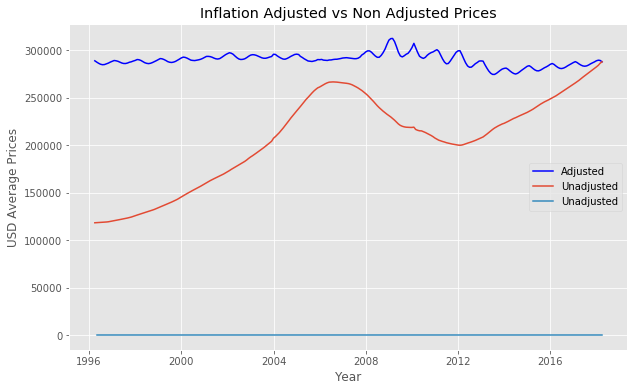

In [232]:
plt.figure(figsize=(10,6))
plt.plot(inflation_merged['infl_adj_value'], color='blue', label='Adjusted')
plt.plot(df, label='Unadjusted')
plt.xlabel('Year')
plt.ylabel('USD Average Prices')
plt.legend()
plt.title('Inflation Adjusted vs Non Adjusted Prices')
plt.show()

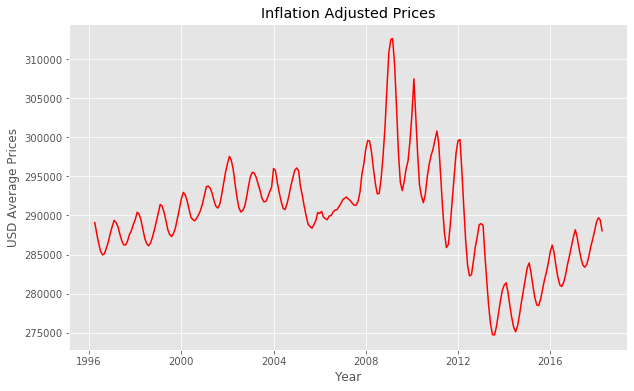

In [70]:
plt.figure(figsize=(10,6))
plt.plot(inflation_merged['infl_adj_value'], color='red')
plt.xlabel('Year')
plt.ylabel('USD Average Prices')
plt.title('Inflation Adjusted Prices')
plt.show()

It looks like there is some seasonality here, as well as clear up and downtrends.

In [233]:
adftest(inflation_merged['infl_adj_value'])

Test Statistic                  -1.704683
p-value                          0.428701
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [72]:
to_drop= list(data.columns[7:])

In [73]:
data.drop(columns=to_drop, axis=1, inplace=True)

In [74]:
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'],
      dtype='object')

# Checking for Stationarity

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
value    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


### Unadjusted Data

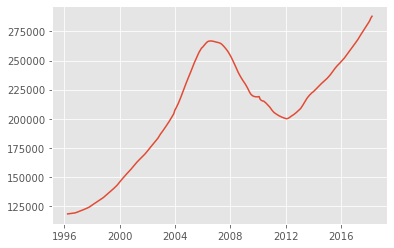

In [76]:
plt.plot(df)

In [77]:
df_roll_mean = df.rolling(window=12).mean()
df_roll_std = df.rolling(window=12).std()

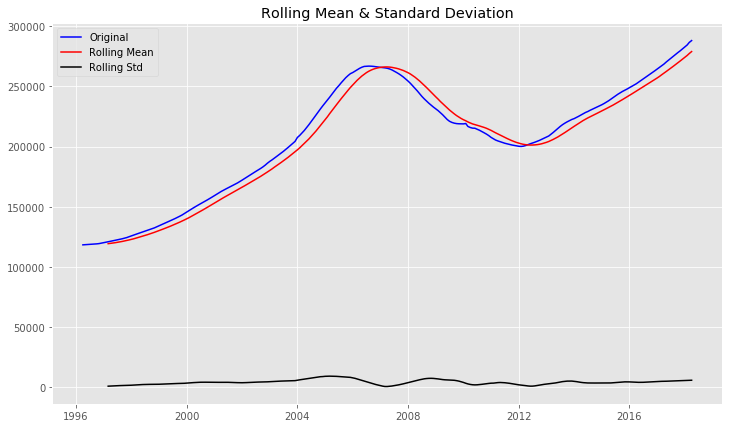

In [78]:
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(df_roll_mean, color='red', label='Rolling Mean')
plt.plot(df_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [79]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['value'])

In [80]:
adftest(df['value'])

Test Statistic                  -1.885145
p-value                          0.339082
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


HO : Non Stationary 

Ha : Stationary

Test Statistic is higher than critical value at all confidence levels. We fail to reject the null hypothesis. THe time series is non stationary

Data will need to be converted to stationary.

### Adjusted Data

In [81]:
infladj_roll_mean = inflation_merged['infl_adj_value'].rolling(window=12).mean()
infladj_roll_std = inflation_merged['infl_adj_value'].rolling(window=12).std()

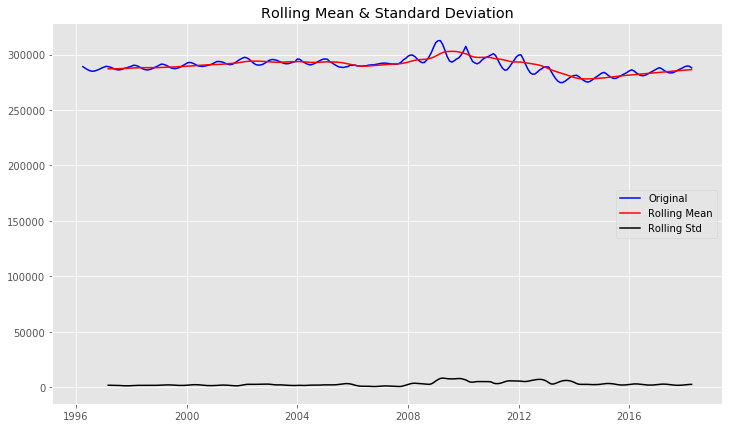

In [82]:
fig = plt.figure(figsize=(12,7))
plt.plot(inflation_merged['infl_adj_value'], color='blue', label='Original')
plt.plot(infladj_roll_mean, color='red', label='Rolling Mean')
plt.plot(infladj_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [83]:
adftest(inflation_merged['infl_adj_value'])

Test Statistic                  -1.704683
p-value                          0.428701
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


Still not stationary, will need to decompose the data

# Removing Trends

In [84]:
import numpy as np

### Taking the log of the data

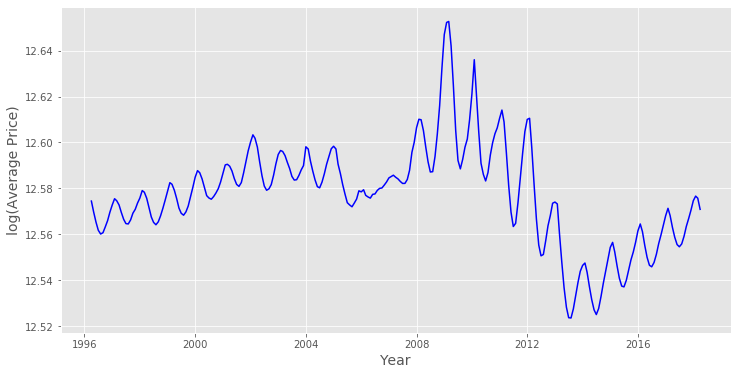

In [234]:
data_log = pd.Series(np.log(inflation_merged['infl_adj_value']))
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('log(Average Price)', fontsize=14)
plt.show()

In [235]:
adftest(data_log)

Test Statistic                  -1.728436
p-value                          0.416524
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


### Calculating the Rolling Mean

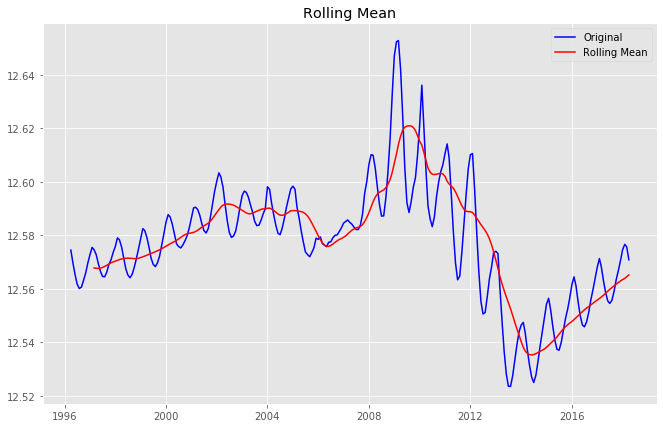

In [236]:
roll_mean = data_log.rolling(window=12).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

In [87]:
data_minus_roll_mean = data - roll_mean
data_minus_roll_mean.head(15)

1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01         NaN
1996-08-01         NaN
1996-09-01         NaN
1996-10-01         NaN
1996-11-01         NaN
1996-12-01         NaN
1997-01-01         NaN
1997-02-01         NaN
1997-03-01    0.006833
1997-04-01    0.005133
1997-05-01    0.001885
1997-06-01   -0.001230
Name: infl_adj_value, dtype: float64

In [88]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

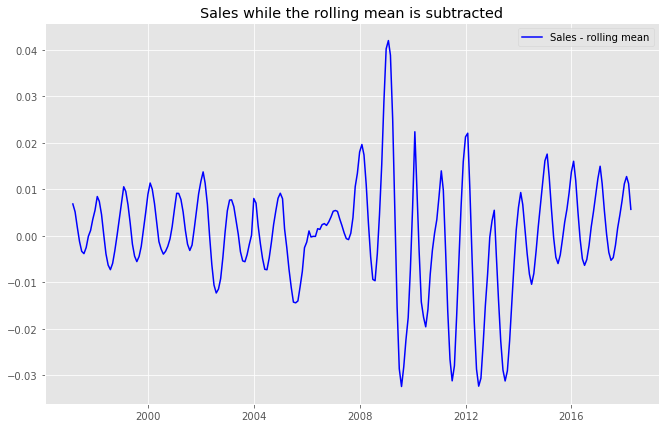

In [89]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [90]:
adftest(data_minus_roll_mean)

Test Statistic                  -2.431348
p-value                          0.133084
#Lags Used                      14.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


Eyeballing the graph, it looks like we have improved it slightly, but still does not look stationary. Dickey Fuller test confims this.


### Exponentially Weighted Rolling Mean

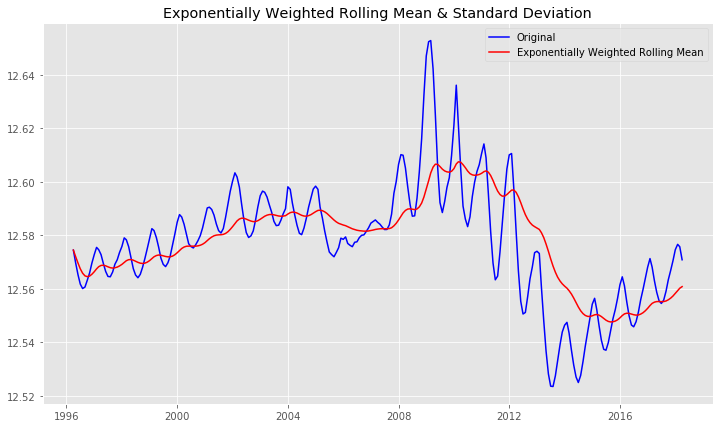

In [91]:
exp_roll_mean = data.ewm(halflife=12).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [92]:
data_minus_exp_roll_mean = data - exp_roll_mean
data_minus_exp_roll_mean.head(15)

1996-04-01    0.000000
1996-05-01   -0.002325
1996-06-01   -0.004358
1996-07-01   -0.005724
1996-08-01   -0.005730
1996-09-01   -0.004171
1996-10-01   -0.001384
1996-11-01    0.001166
1996-12-01    0.004144
1997-01-01    0.006380
1997-02-01    0.008029
1997-03-01    0.006360
1997-04-01    0.004040
1997-05-01    0.000700
1997-06-01   -0.002087
Name: infl_adj_value, dtype: float64

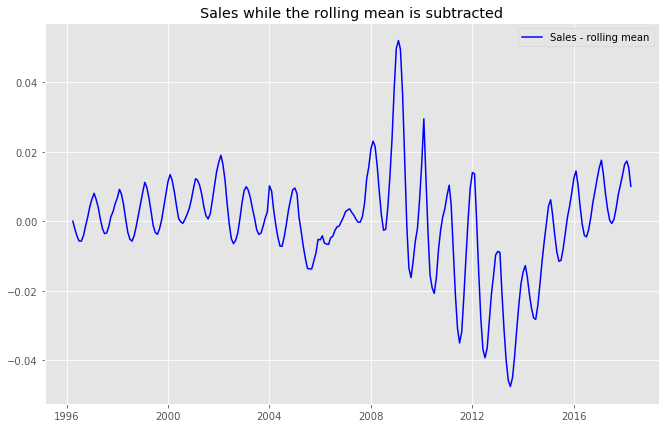

In [93]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [94]:
data_diff = data.diff(periods=1)
data_diff.head(10)

1996-04-01         NaN
1996-05-01   -0.004789
1996-06-01   -0.004408
1996-07-01   -0.003505
1996-08-01   -0.001657
1996-09-01    0.000570
1996-10-01    0.002506
1996-11-01    0.002759
1996-12-01    0.003645
1997-01-01    0.003171
Name: infl_adj_value, dtype: float64

In [95]:
data_diff.dropna(inplace=True)

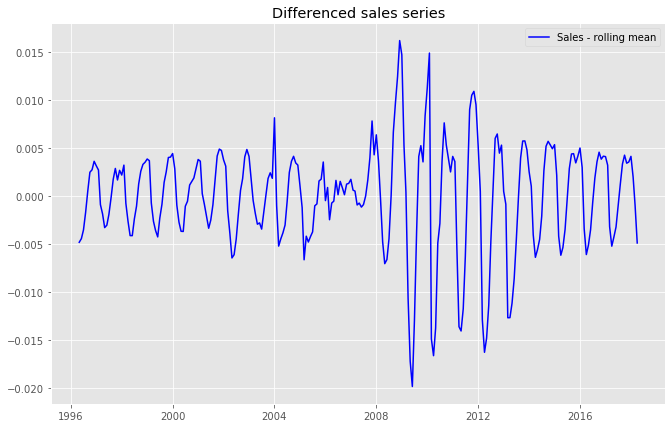

In [96]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [97]:
adftest(data_diff)

Test Statistic                  -3.807765
p-value                          0.002829
#Lags Used                      13.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


Looks like it is stationary here

In [98]:
data_diff2 = data.diff(periods=3)
data_diff2.head(10)

1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01   -0.012702
1996-08-01   -0.009571
1996-09-01   -0.004592
1996-10-01    0.001418
1996-11-01    0.005834
1996-12-01    0.008909
1997-01-01    0.009574
Name: infl_adj_value, dtype: float64

In [99]:
data_diff2.dropna(inplace=True)

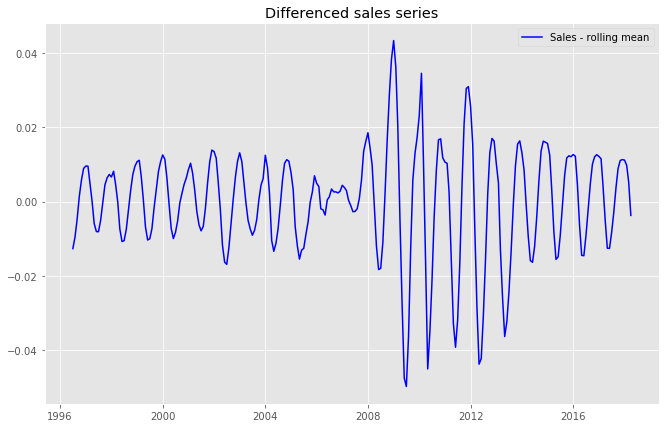

In [100]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff2, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [101]:
adftest(data_diff2)

Test Statistic                  -2.918598
p-value                          0.043228
#Lags Used                      14.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [102]:
data_diff3 = data.diff(periods=6)
data_diff3.head(10)

1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01         NaN
1996-08-01         NaN
1996-09-01         NaN
1996-10-01   -0.011284
1996-11-01   -0.003736
1996-12-01    0.004317
1997-01-01    0.010993
Name: infl_adj_value, dtype: float64

In [103]:
data_diff3.dropna(inplace=True)

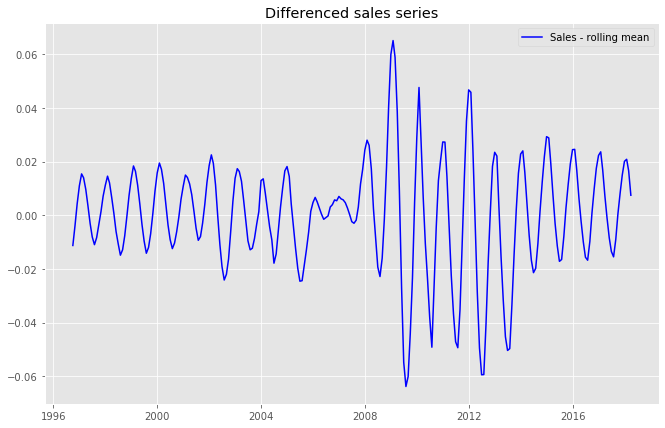

In [104]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff3, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [105]:
data_diff4 = data.diff(periods=12)
data_diff4.head(10)

1996-04-01   NaN
1996-05-01   NaN
1996-06-01   NaN
1996-07-01   NaN
1996-08-01   NaN
1996-09-01   NaN
1996-10-01   NaN
1996-11-01   NaN
1996-12-01   NaN
1997-01-01   NaN
Name: infl_adj_value, dtype: float64

In [106]:
data_diff4.dropna(inplace=True)

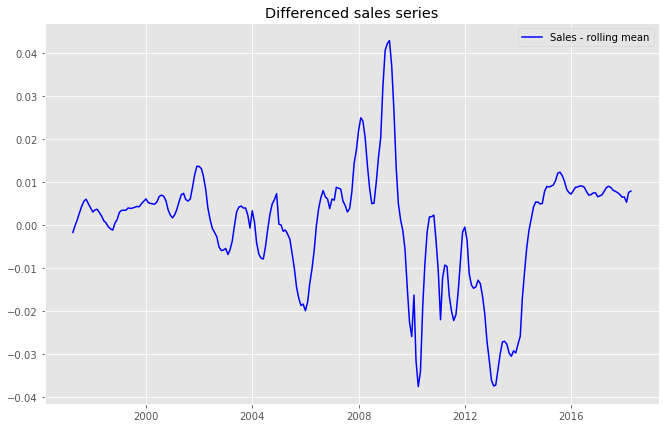

In [121]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff4, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [122]:
adftest(data_diff4)

Test Statistic                  -2.671259
p-value                          0.079145
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


6 month lag gives best results it seems, will try stationarity test on it now.

In [123]:
data_diff4

1997-04-01   -0.001677
1997-05-01   -0.000149
1997-06-01    0.001249
1997-07-01    0.002880
1997-08-01    0.004398
                ...   
2017-12-01    0.006512
2018-01-01    0.006538
2018-02-01    0.005318
2018-03-01    0.007579
2018-04-01    0.007913
Name: infl_adj_value, Length: 253, dtype: float64

In [124]:
dftest_diff4 = adfuller(data_diff4)

In [125]:
dfoutput_diff4 = pd.Series(dftest_diff4[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_diff4[4].items():
    dfoutput_diff4['Critical Value (%s)'%key] = value
print(dftest_diff4)



print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff4)

(-2.6712589709185335, 0.07914512947480834, 16, 236, {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}, -2115.9638025241875)
Results of Dickey-Fuller test: 

Test Statistic                  -2.671259
p-value                          0.079145
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


# sqrt

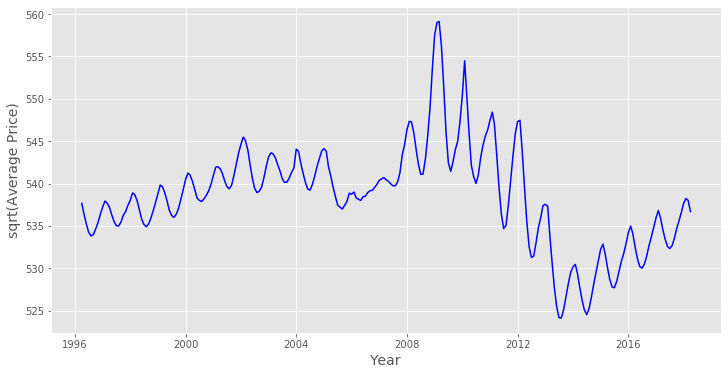

In [126]:
data2 = pd.Series(np.sqrt(inflation_merged['infl_adj_value']))
fig = plt.figure(figsize=(12,6))
plt.plot(data2, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('sqrt(Average Price)', fontsize=14)
plt.show()

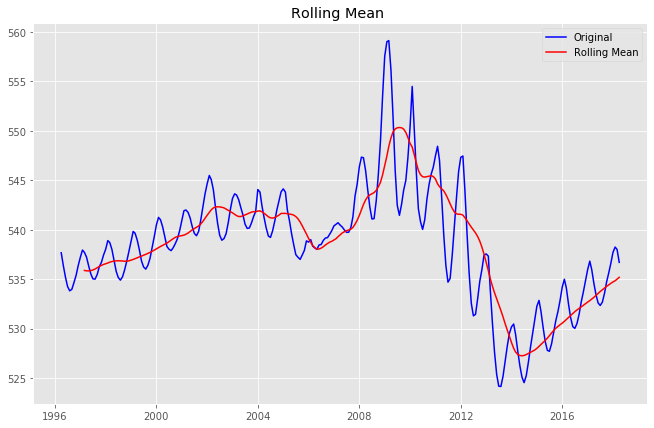

In [127]:
roll_mean = data2.rolling(window=12).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data2, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean ')
plt.show(block=False)

In [128]:
data_diff5 = data2.diff(periods=6)
data_diff5.head(10)

1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01         NaN
1996-08-01         NaN
1996-09-01         NaN
1996-10-01   -3.024961
1996-11-01   -1.001123
1996-12-01    1.156355
1997-01-01    2.944490
Name: infl_adj_value, dtype: float64

In [129]:
data_diff5.dropna(inplace=True)

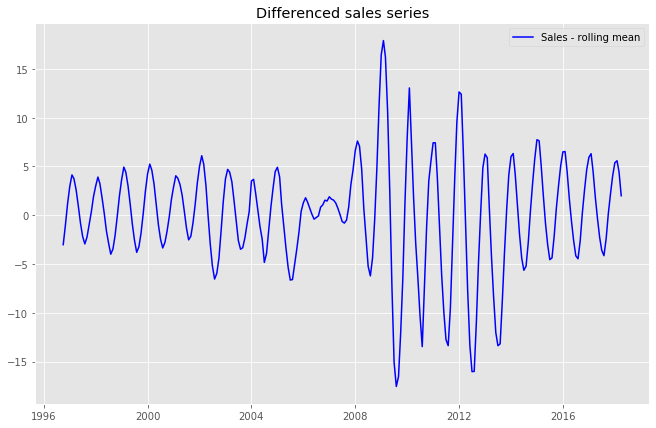

In [130]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff5, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [131]:
adftest(data_diff5)

Test Statistic                  -3.042938
p-value                          0.031074
#Lags Used                      13.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


290098.24788696 1.0000133102301445 0.9999622460834626


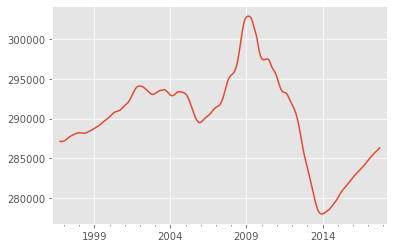

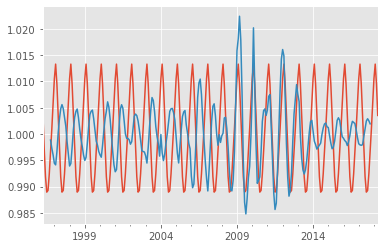

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(inflation_merged['infl_adj_value'],model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print(trend.mean(),seasonal.mean(),residual.mean())

trend.plot()
plt.show()
seasonal.plot()
residual.plot()
plt.show()

-1.1359442897553446e-05 1.3141844514975812e-19 1.2360310006821834e-05


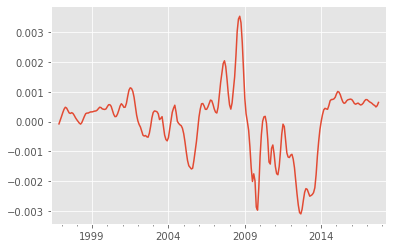

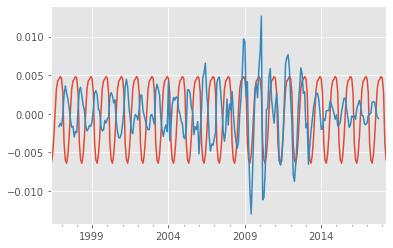

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_diff,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print(trend.mean(),seasonal.mean(),residual.mean())

trend.plot()
plt.show()
seasonal.plot()
residual.plot()
plt.show()

# Models

In [134]:
data_diff

1996-05-01   -0.004789
1996-06-01   -0.004408
1996-07-01   -0.003505
1996-08-01   -0.001657
1996-09-01    0.000570
                ...   
2017-12-01    0.003574
2018-01-01    0.004159
2018-02-01    0.002015
2018-03-01   -0.000903
2018-04-01   -0.004859
Name: infl_adj_value, Length: 264, dtype: float64

# ARMA MODEL

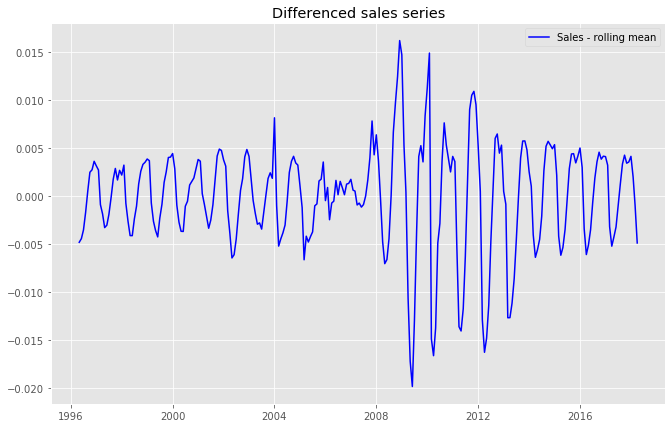

In [196]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

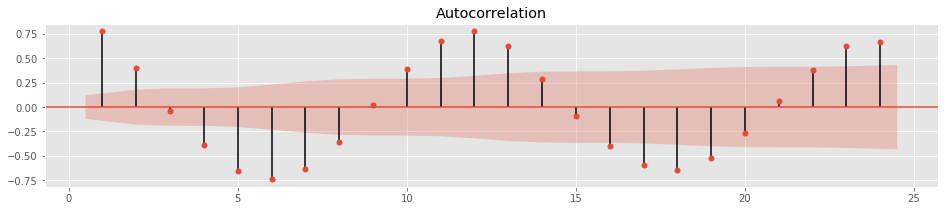

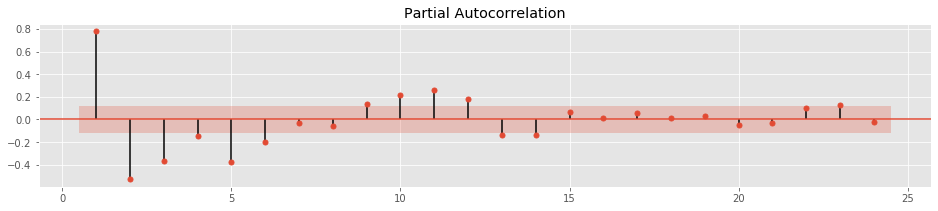

In [139]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff, ax=ax, lags=24, zero=False);

In [237]:
auto_arima(data_diff,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1195.556
Date:                Tue, 05 May 2020   AIC                          -2381.112
Time:                        14:59:01   BIC                          -2363.232
Sample:                             0   HQIC                         -2373.927
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.785e-06   6.27e-05     -0.156      0.876      -0.000       0.000
ar.L1          1.6532      0.036     45.531      0.000       1.582       1.724
ar.L2         -0.9127      0.030    -30.224      0.000      -0.972      -0.854
ma.L1         -0.7112      0.052    -13.573      0.000      -0.814      -0.609
sigma2      6.717e-06    2.6e-07     25.857      0.000    6.21e-06    7.23e-06
===================================================================================
Ljung-Box (Q):                      109.54   Jarque-Bera (JB):             11348.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.57   Skew:                            -3.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
mod_ar1 = ARMA(data_diff, order=(1,0))
res_ar1 = mod_ar1.fit()
res_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(1, 0)   Log Likelihood                1121.889
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2237.778
Time:                        13:59:02   BIC                          -2227.050
Sample:                    05-01-1996   HQIC                         -2233.467
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0001      0.001     -0.146      0.884      -0.002       0.002
ar.L1.infl_adj_value     0.7793      0.038     20.334      0.000       0.704       0.854
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2831           +0.0000j            1.2831            0.0000
-----------------------------------------------------------------------------
"""

In [142]:
mod_ar2 = ARMA(data_diff, order=(2,0))
res_ar2 = mod_ar2.fit()
res_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(2, 0)   Log Likelihood                1165.024
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2322.048
Time:                        13:59:03   BIC                          -2307.744
Sample:                    05-01-1996   HQIC                         -2316.300
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.414e-05      0.001     -0.101      0.920      -0.001       0.001
ar.L1.infl_adj_value     1.1922      0.052     22.867      0.000       1.090       1.294
ar.L2.infl_adj_value    -0.5279      0.052    -10.137      0.000      -0.630      -0.426
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1291           -0.7869j            1.3763           -0.0969
AR.2            1.1291           +0.7869j            1.3763            0.0969
-----------------------------------------------------------------------------
"""

In [143]:
mod_ar3 = ARMA(data_diff, order=(3,0))
res_ar3 = mod_ar3.fit()
res_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(3, 0)   Log Likelihood                1183.330
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2356.659
Time:                        13:59:03   BIC                          -2338.779
Sample:                    05-01-1996   HQIC                         -2349.474
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -3.27e-05      0.000     -0.089      0.929      -0.001       0.001
ar.L1.infl_adj_value     1.0014      0.057     17.494      0.000       0.889       1.114
ar.L2.infl_adj_value    -0.0984      0.084     -1.172      0.242      -0.263       0.066
ar.L3.infl_adj_value    -0.3593      0.057     -6.279      0.000      -0.471      -0.247
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9432           -0.6313j            1.1350           -0.0939
AR.2            0.9432           +0.6313j            1.1350            0.0939
AR.3           -2.1604           -0.0000j            2.1604           -0.5000
-----------------------------------------------------------------------------
"""

In [144]:
mod_ar4 = ARMA(data_diff, order=(4,0))
res_ar4 = mod_ar4.fit()
res_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(4, 0)   Log Likelihood                1186.175
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2360.350
Time:                        13:59:04   BIC                          -2338.895
Sample:                    05-01-1996   HQIC                         -2351.729
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -2.78e-05      0.000     -0.087      0.931      -0.001       0.001
ar.L1.infl_adj_value     0.9484      0.061     15.604      0.000       0.829       1.068
ar.L2.infl_adj_value    -0.1125      0.083     -1.351      0.178      -0.276       0.051
ar.L3.infl_adj_value    -0.2133      0.083     -2.565      0.011      -0.376      -0.050
ar.L4.infl_adj_value    -0.1456      0.061     -2.399      0.017      -0.265      -0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9241           -0.5944j            1.0988           -0.0910
AR.2            0.9241           +0.5944j            1.0988            0.0910
AR.3           -1.6566           -1.7160j            2.3852           -0.3722
AR.4           -1.6566           +1.7160j            2.3852            0.3722
-----------------------------------------------------------------------------
"""

In [145]:
mod_ar5 = ARMA(data_diff, order=(5,0))
res_ar5 = mod_ar5.fit()
res_ar5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(5, 0)   Log Likelihood                1204.598
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2395.196
Time:                        13:59:05   BIC                          -2370.165
Sample:                    05-01-1996   HQIC                         -2385.138
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.832e-05      0.000     -0.084      0.933      -0.000       0.000
ar.L1.infl_adj_value     0.8947      0.057     15.640      0.000       0.783       1.007
ar.L2.infl_adj_value    -0.1896      0.078     -2.419      0.016      -0.343      -0.036
ar.L3.infl_adj_value    -0.2533      0.078     -3.268      0.001      -0.405      -0.101
ar.L4.infl_adj_value     0.1954      0.078      2.497      0.013       0.042       0.349
ar.L5.infl_adj_value    -0.3591      0.057     -6.309      0.000      -0.471      -0.248
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9022           -0.5365j            1.0497           -0.0854
AR.2            0.9022           +0.5365j            1.0497            0.0854
AR.3           -1.3052           -0.0000j            1.3052           -0.5000
AR.4            0.0225           -1.3913j            1.3915           -0.2474
AR.5            0.0225           +1.3913j            1.3915            0.2474
-----------------------------------------------------------------------------
"""

In [146]:
mod_ar6 = ARMA(data_diff, order=(6,0))
res_ar6 = mod_ar6.fit()
res_ar6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(6, 0)   Log Likelihood                1209.406
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 May 2020   AIC                          -2402.812
Time:                        13:59:06   BIC                          -2374.204
Sample:                    05-01-1996   HQIC                         -2391.317
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.552e-05      0.000     -0.086      0.932      -0.000       0.000
ar.L1.infl_adj_value     0.8254      0.060     13.677      0.000       0.707       0.944
ar.L2.infl_adj_value    -0.1519      0.078     -1.951      0.052      -0.305       0.001
ar.L3.infl_adj_value    -0.3015      0.078     -3.876      0.000      -0.454      -0.149
ar.L4.infl_adj_value     0.1597      0.078      2.056      0.041       0.007       0.312
ar.L5.infl_adj_value    -0.1909      0.078     -2.460      0.015      -0.343      -0.039
ar.L6.infl_adj_value    -0.1879      0.060     -3.132      0.002      -0.305      -0.070
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8971           -0.5198j            1.0369           -0.0836
AR.2            0.8971           +0.5198j            1.0369            0.0836
AR.3            0.2298           -1.2792j            1.2997           -0.2217
AR.4            0.2298           +1.2792j            1.2997            0.2217
AR.5           -1.6349           -0.5078j            1.7120           -0.4521
AR.6           -1.6349           +0.5078j            1.7120            0.4521
-----------------------------------------------------------------------------
"""

In [147]:
mod_ar7 = ARMA(data_diff, order=(7,0))
res_ar7 = mod_ar7.fit()
res_ar7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(7, 0)   Log Likelihood                1209.531
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 May 2020   AIC                          -2401.062
Time:                        13:59:07   BIC                          -2368.879
Sample:                    05-01-1996   HQIC                         -2388.130
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.528e-05      0.000     -0.087      0.931      -0.000       0.000
ar.L1.infl_adj_value     0.8195      0.061     13.333      0.000       0.699       0.940
ar.L2.infl_adj_value    -0.1578      0.079     -2.004      0.046      -0.312      -0.003
ar.L3.infl_adj_value    -0.2965      0.078     -3.783      0.000      -0.450      -0.143
ar.L4.infl_adj_value     0.1503      0.080      1.882      0.061      -0.006       0.307
ar.L5.infl_adj_value    -0.1954      0.078     -2.502      0.013      -0.349      -0.042
ar.L6.infl_adj_value    -0.1627      0.078     -2.075      0.039      -0.316      -0.009
ar.L7.infl_adj_value    -0.0306      0.061     -0.500      0.617      -0.150       0.089
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8972           -0.5175j            1.0357           -0.0833
AR.2            0.8972           +0.5175j            1.0357            0.0833
AR.3            0.2677           -1.2889j            1.3164           -0.2174
AR.4            0.2677           +1.2889j            1.3164            0.2174
AR.5           -1.7093           -0.0000j            1.7093           -0.5000
AR.6           -2.9705           -1.2127j            3.2085           -0.4383
AR.7           -2.9705           +1.2127j            3.2085            0.4383
-----------------------------------------------------------------------------
"""

In [148]:
df['res_price'] = res_ar7.resid

In [149]:
df.res_price.mean()

-1.8712924006758304e-05

In [150]:
df.res_price.var()

6.1627726383118984e-06

In [151]:
pp = df.res_price.dropna()

In [152]:
adftest(pp)

Test Statistic                  -2.451633
p-value                          0.127690
#Lags Used                      12.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [153]:
import statsmodels.graphics.tsaplots as sgt

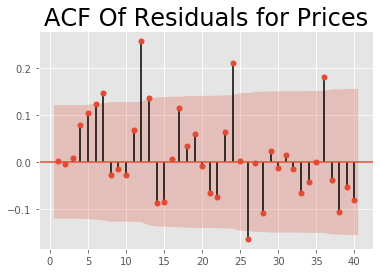

In [154]:
sgt.plot_acf(pp, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

In [155]:
mod_ma1 = ARMA(data_diff, order=(0,1))
res_ma1 = mod_ma1.fit()
res_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 1)   Log Likelihood                1091.238
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 04 May 2020   AIC                          -2176.476
Time:                        13:59:11   BIC                          -2165.748
Sample:                    05-01-1996   HQIC                         -2172.165
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.227e-05      0.000     -0.080      0.936      -0.001       0.001
ma.L1.infl_adj_value     0.6917      0.033     20.970      0.000       0.627       0.756
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4458           +0.0000j            1.4458            0.5000
-----------------------------------------------------------------------------
"""

In [159]:
mod_ma1 = ARMA(data_diff, order=(0,1))
res_ma1 = mod_ma1.fit()
res_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 1)   Log Likelihood                1091.238
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 04 May 2020   AIC                          -2176.476
Time:                        13:59:42   BIC                          -2165.748
Sample:                    05-01-1996   HQIC                         -2172.165
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.227e-05      0.000     -0.080      0.936      -0.001       0.001
ma.L1.infl_adj_value     0.6917      0.033     20.970      0.000       0.627       0.756
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4458           +0.0000j            1.4458            0.5000
-----------------------------------------------------------------------------
"""

In [160]:
mod_ma2 = ARMA(data_diff, order=(0,2))
res_ma2 = mod_ma2.fit()
res_ma2.summary()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [161]:
mod_ma3 = ARMA(data_diff, order=(0,3))
res_ma3 = mod_ma3.fit()
res_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 3)   Log Likelihood                1158.621
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2307.243
Time:                        14:00:01   BIC                          -2289.363
Sample:                    05-01-1996   HQIC                         -2300.058
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -6.39e-05      0.001     -0.110      0.913      -0.001       0.001
ma.L1.infl_adj_value     1.0850      0.057     18.948      0.000       0.973       1.197
ma.L2.infl_adj_value     0.8292      0.062     13.392      0.000       0.708       0.951
ma.L3.infl_adj_value     0.2551      0.060      4.269      0.000       0.138       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.5673           -1.2373j            1.3612           -0.3184
MA.2           -0.5673           +1.2373j            1.3612            0.3184
MA.3           -2.1159           -0.0000j            2.1159           -0.5000
-----------------------------------------------------------------------------
"""

In [162]:
mod_ma4 = ARMA(data_diff, order=(0,4))
res_ma4 = mod_ma4.fit()
res_ma4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 4)   Log Likelihood                1163.970
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2315.941
Time:                        14:00:20   BIC                          -2294.485
Sample:                    05-01-1996   HQIC                         -2307.319
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.883e-05      0.001     -0.118      0.906      -0.001       0.001
ma.L1.infl_adj_value     1.1040      0.061     18.020      0.000       0.984       1.224
ma.L2.infl_adj_value     0.9720      0.080     12.188      0.000       0.816       1.128
ma.L3.infl_adj_value     0.4391      0.074      5.910      0.000       0.293       0.585
ma.L4.infl_adj_value     0.2103      0.063      3.359      0.001       0.088       0.333
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.9916           -0.9396j            1.3661           -0.3793
MA.2           -0.9916           +0.9396j            1.3661            0.3793
MA.3           -0.0525           -1.5955j            1.5964           -0.2552
MA.4           -0.0525           +1.5955j            1.5964            0.2552
-----------------------------------------------------------------------------
"""

In [164]:
mod_ma6 = ARMA(data_diff, order=(0,6))
res_ma6 = mod_ma6.fit()
res_ma6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 6)   Log Likelihood                1167.090
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2318.181
Time:                        14:00:52   BIC                          -2289.573
Sample:                    05-01-1996   HQIC                         -2306.685
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.316e-05      0.000     -0.090      0.929      -0.001       0.000
ma.L1.infl_adj_value     0.9914      0.074     13.434      0.000       0.847       1.136
ma.L2.infl_adj_value     0.6179      0.089      6.932      0.000       0.443       0.793
ma.L3.infl_adj_value    -0.0866      0.110     -0.786      0.432      -0.303       0.129
ma.L4.infl_adj_value    -0.3794      0.133     -2.844      0.005      -0.641      -0.118
ma.L5.infl_adj_value    -0.4296      0.081     -5.277      0.000      -0.589      -0.270
ma.L6.infl_adj_value    -0.2775      0.063     -4.379      0.000      -0.402      -0.153
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2255           -0.0000j            1.2255           -0.0000
MA.2            0.0407           -1.2697j            1.2704           -0.2449
MA.3            0.0407           +1.2697j            1.2704            0.2449
MA.4           -0.7548           -0.8858j            1.1638           -0.3623
MA.5           -0.7548           +0.8858j            1.1638            0.3623
MA.6           -1.3456           -0.0000j            1.3456           -0.5000
-----------------------------------------------------------------------------
"""

In [165]:
mod_ma7 = ARMA(data_diff, order=(0,7))
res_ma7 = mod_ma7.fit()
res_ma7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(0, 7)   Log Likelihood                1176.675
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2335.349
Time:                        14:01:35   BIC                          -2303.165
Sample:                    05-01-1996   HQIC                         -2322.417
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.861e-05      0.000     -0.123      0.902      -0.000       0.000
ma.L1.infl_adj_value     0.9556      0.061     15.795      0.000       0.837       1.074
ma.L2.infl_adj_value     0.6482      0.074      8.816      0.000       0.504       0.792
ma.L3.infl_adj_value     0.0927      0.081      1.139      0.256      -0.067       0.252
ma.L4.infl_adj_value    -0.1555      0.091     -1.706      0.089      -0.334       0.023
ma.L5.infl_adj_value    -0.4605      0.073     -6.337      0.000      -0.603      -0.318
ma.L6.infl_adj_value    -0.5032      0.074     -6.780      0.000      -0.649      -0.358
ma.L7.infl_adj_value    -0.2456      0.054     -4.560      0.000      -0.351      -0.140
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1566           -0.0000j            1.1566           -0.0000
MA.2            0.3041           -1.1194j            1.1600           -0.2078
MA.3            0.3041           +1.1194j            1.1600            0.2078
MA.4           -0.6561           -0.9780j            1.1777           -0.3440
MA.5           -0.6561           +0.9780j            1.1777            0.3440
MA.6           -1.2506           -0.5676j            1.3733           -0.4322
MA.7           -1.2506           +0.5676j            1.3733            0.4322
-----------------------------------------------------------------------------
"""

In [166]:
mod_ma9 = ARMA(data_diff, order=(0,9))
res_ma9 = mod_ma9.fit()
res_ma9.summary()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [167]:
mod_ma10 = ARMA(data_diff, order=(0,10))
res_ma10 = mod_ma10.fit()
res_ma10.summary()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [191]:

mod_arma_1_1 = ARMA(data_diff, order=(1,1))
res_arma_1_1 = mod_arma_1_1.fit()
res_arma_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(1, 1)   Log Likelihood                1142.791
Method:                       css-mle   S.D. of innovations              0.003
Date:                Mon, 04 May 2020   AIC                          -2277.582
Time:                        14:35:17   BIC                          -2263.278
Sample:                    05-01-1996   HQIC                         -2271.834
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0001      0.001     -0.134      0.894      -0.002       0.002
ar.L1.infl_adj_value     0.6807      0.050     13.681      0.000       0.583       0.778
ma.L1.infl_adj_value     0.3530      0.049      7.133      0.000       0.256       0.450
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4691           +0.0000j            1.4691            0.0000
MA.1           -2.8329           +0.0000j            2.8329            0.5000
-----------------------------------------------------------------------------
"""

In [192]:

mod_arma_3_3 = ARMA(data_diff, order=(3,3))
res_arma_3_3 = mod_arma_3_3.fit()
res_arma_3_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(3, 3)   Log Likelihood                1211.824
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 May 2020   AIC                          -2407.648
Time:                        14:35:46   BIC                          -2379.041
Sample:                    05-01-1996   HQIC                         -2396.153
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.474e-05      0.000     -0.058      0.954      -0.001       0.000
ar.L1.infl_adj_value     2.1307      0.120     17.719      0.000       1.895       2.366
ar.L2.infl_adj_value    -1.6970      0.205     -8.288      0.000      -2.098      -1.296
ar.L3.infl_adj_value     0.4086      0.117      3.498      0.001       0.180       0.638
ma.L1.infl_adj_value    -1.4125      0.116    -12.153      0.000      -1.640      -1.185
ma.L2.infl_adj_value     0.5285      0.151      3.507      0.001       0.233       0.824
ma.L3.infl_adj_value     0.1528      0.074      2.071      0.039       0.008       0.297
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8707           -0.5066j            1.0074           -0.0839
AR.2            0.8707           +0.5066j            1.0074            0.0839
AR.3            2.4116           -0.0000j            2.4116           -0.0000
MA.1            0.9688           -0.5235j            1.1012           -0.0789
MA.2            0.9688           +0.5235j            1.1012            0.0789
MA.3           -5.3953           -0.0000j            5.3953           -0.5000
-----------------------------------------------------------------------------
"""

In [194]:

mod_arma_3_2 = ARMA(data_diff, order=(3,2))
res_arma_3_2 = mod_arma_3_2.fit()
res_arma_3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(3, 2)   Log Likelihood                1209.936
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 May 2020   AIC                          -2405.872
Time:                        14:37:32   BIC                          -2380.841
Sample:                    05-01-1996   HQIC                         -2395.814
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.589e-05      0.000     -0.059      0.953      -0.001       0.001
ar.L1.infl_adj_value     2.2690      0.075     30.407      0.000       2.123       2.415
ar.L2.infl_adj_value    -1.9341      0.127    -15.255      0.000      -2.183      -1.686
ar.L3.infl_adj_value     0.5455      0.072      7.579      0.000       0.404       0.687
ma.L1.infl_adj_value    -1.5974      0.056    -28.335      0.000      -1.708      -1.487
ma.L2.infl_adj_value     0.8092      0.059     13.832      0.000       0.695       0.924
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8720           -0.5072j            1.0087           -0.0838
AR.2            0.8720           +0.5072j            1.0087            0.0838
AR.3            1.8015           -0.0000j            1.8015           -0.0000
MA.1            0.9870           -0.5115j            1.1116           -0.0761
MA.2            0.9870           +0.5115j            1.1116            0.0761
-----------------------------------------------------------------------------
"""

In [195]:

mod_arma_2_3 = ARMA(data_diff, order=(2,3))
res_arma_2_3 = mod_arma_2_3.fit()
res_arma_2_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         infl_adj_value   No. Observations:                  264
Model:                     ARMA(2, 3)   Log Likelihood                1207.467
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 May 2020   AIC                          -2400.934
Time:                        14:38:04   BIC                          -2375.902
Sample:                    05-01-1996   HQIC                         -2390.875
                         - 04-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -1.23e-05      0.000     -0.059      0.953      -0.000       0.000
ar.L1.infl_adj_value     1.7082      0.013    136.069      0.000       1.684       1.733
ar.L2.infl_adj_value    -0.9791      0.012    -79.342      0.000      -1.003      -0.955
ma.L1.infl_adj_value    -1.0591      0.058    -18.128      0.000      -1.174      -0.945
ma.L2.infl_adj_value     0.1342      0.071      1.890      0.060      -0.005       0.273
ma.L3.infl_adj_value     0.2937      0.052      5.603      0.000       0.191       0.396
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8724           -0.5102j            1.0106           -0.0842
AR.2            0.8724           +0.5102j            1.0106            0.0842
MA.1            1.0077           -0.6013j            1.1735           -0.0856
MA.2            1.0077           +0.6013j            1.1735            0.0856
MA.3           -2.4724           -0.0000j            2.4724           -0.5000
-----------------------------------------------------------------------------
"""



# Step 5: ARIMA Modeling

In [239]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [240]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_diff,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1987.3709601692408
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-2015.7764434062456
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-2107.0777960047417
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-2021.9853175313249
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-2141.726127369866
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-2141.656935368671
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-2021.136123124155
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-2029.163914739041
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-2160.9736484832256
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-2126.6972468873864
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-2153.451976373491
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-2089.640311445087
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-2156.5517652310023
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-2218.412225473699

In [241]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2261.27
Name: 40, dtype: object

In [222]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff, 
                                        order=(2, 0, 1), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6856      0.040     42.005      0.000       1.607       1.764
ar.L2         -0.9139      0.035    -25.924      0.000      -0.983      -0.845
ma.L1         -0.6829      0.060    -11.437      0.000      -0.800      -0.566
sigma2      6.922e-06    2.8e-07     24.757      0.000    6.37e-06    7.47e-06


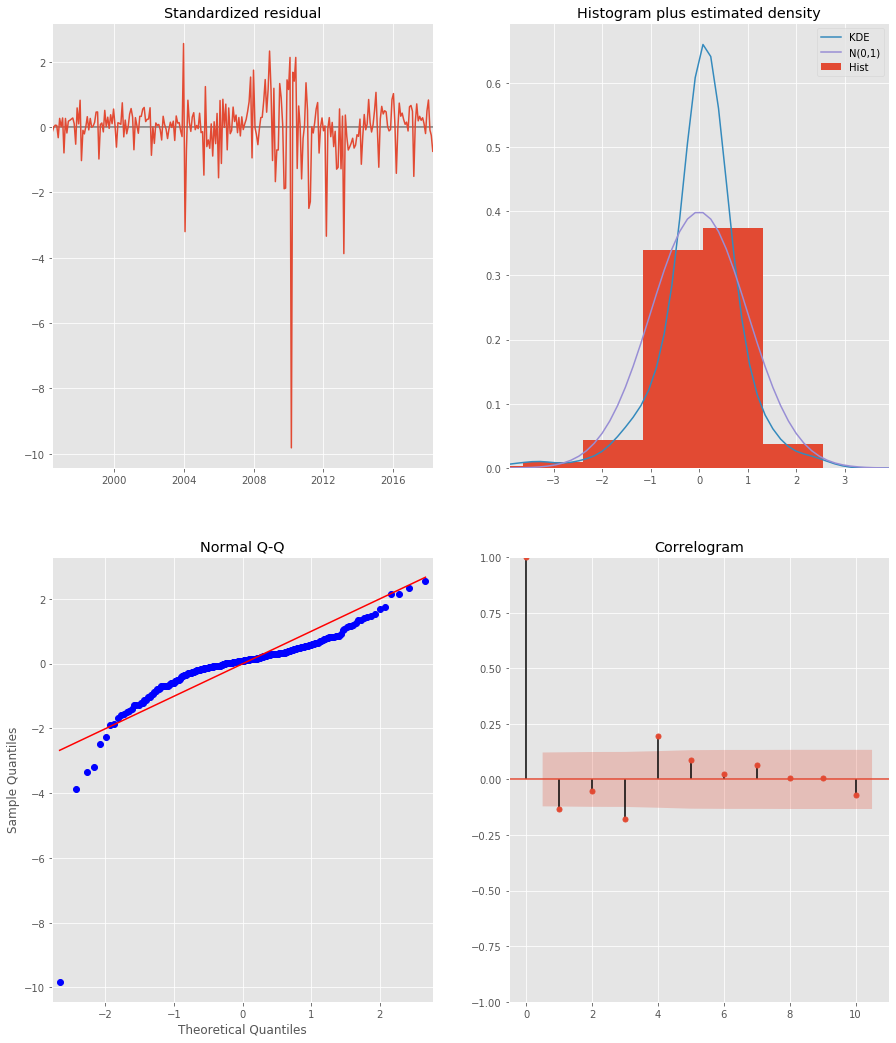

In [223]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [224]:
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

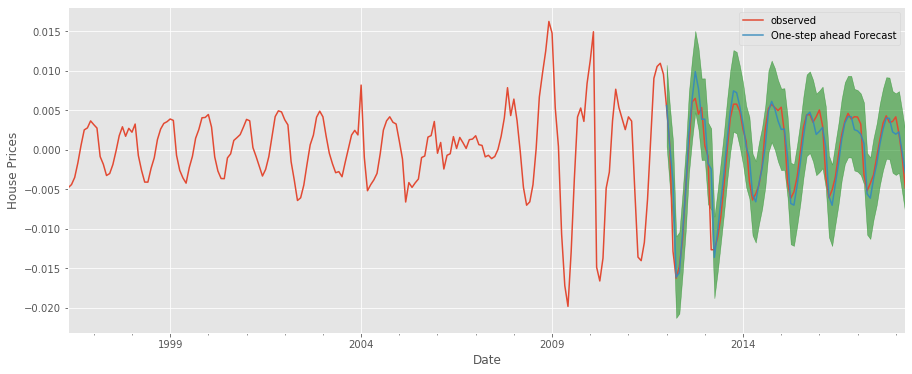

In [225]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [226]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff['2012-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [227]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

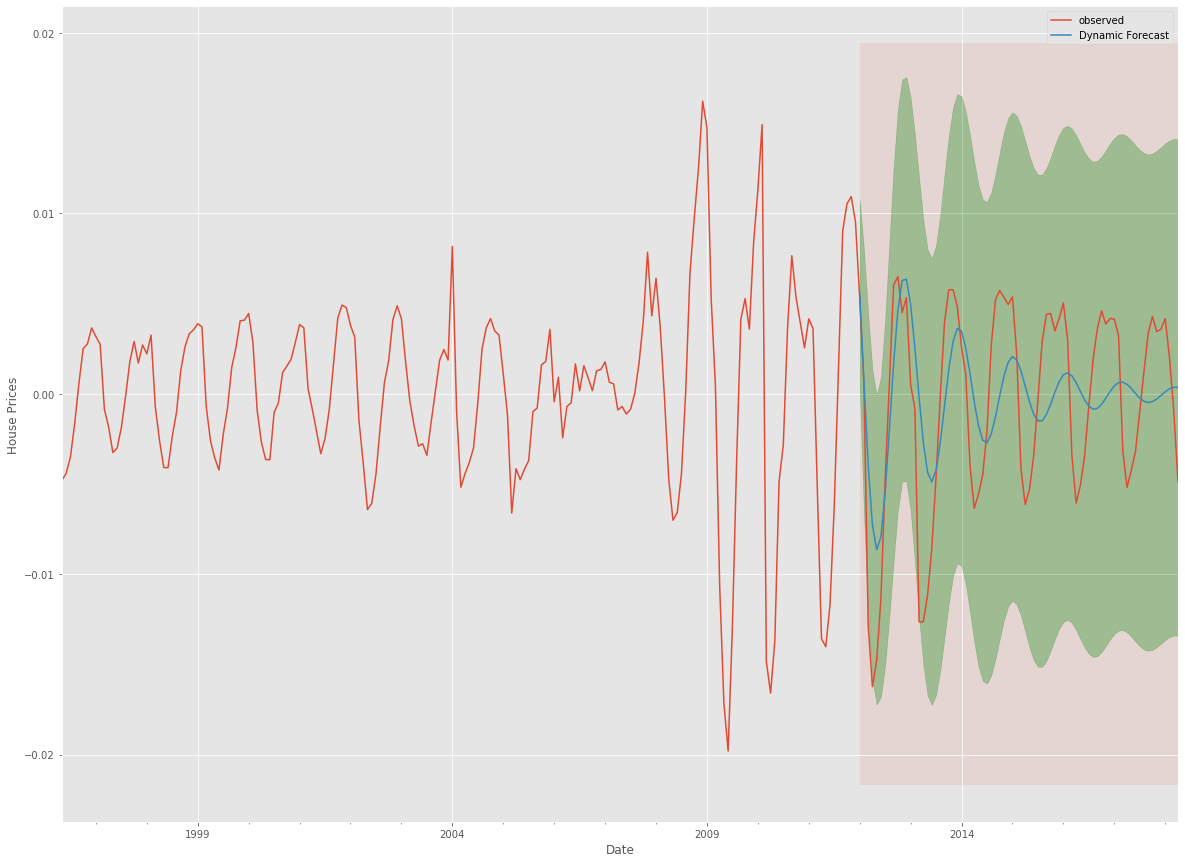

In [228]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [229]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff['2012-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 0.0


In [230]:
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

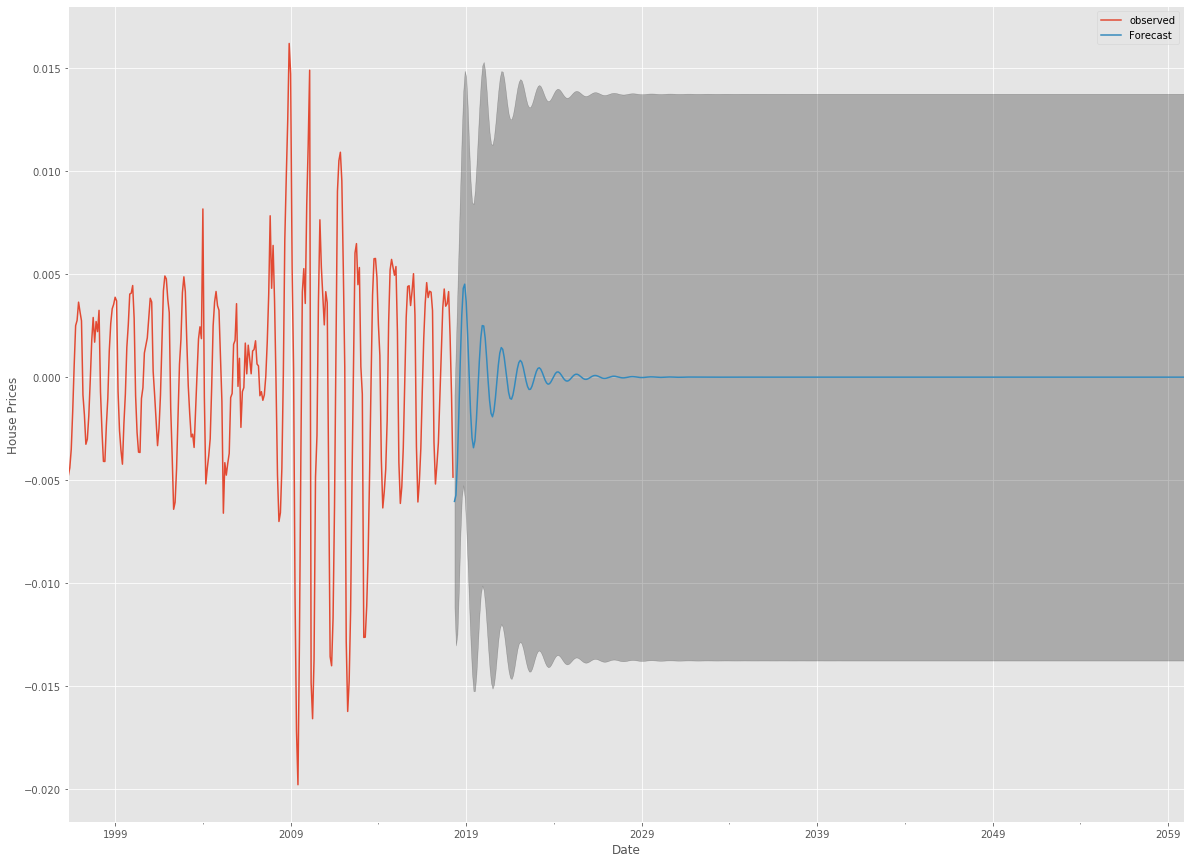

In [231]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

# Step 6: Interpreting Results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(2, 0, 1)   Log Likelihood                1195.556
Date:                Tue, 05 May 2020   AIC                          -2381.112
Time:                        06:16:27   BIC                          -2363.232
Sample:                             0   HQIC                         -2373.927
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.785e-06   6.27e-05     -0.156      0.876      -0.000       0.000
ar.L1          1.6532      0.036     45.531      0.000       1.582       1.724
ar.L2         -0.9127      0.030    -30.224      0.000      -0.972      -0.854
ma.L1         -0.7112      0.052    -13.573      0.000      -0.814      -0.609
sigma2      6.717e-06    2.6e-07     25.857      0.000    6.21e-06    7.23e-06
===================================================================================
Ljung-Box (Q):                      109.54   Jarque-Bera (JB):             11348.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.57   Skew:                            -3.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""